# Wheelchair Control

![](images/wheelchair.jpg)

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Wheelchair Planar Model
================================

### Introduction

We consider a simple model of a wheelchair evolving in the plane. It is mainly made of

  - A frame ; from above, its most visible component is the seat. We assume that it is a square,

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the seat. 
    
We assume that the seat backrest is on top of the wheels common axis.


Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the wheelchait faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the wheelchair moves forward.

### Parameter Definition

From now on, we assume that the seat side length is $L = 50 \mbox{ cm}$ and the wheel radius is $R_w = 30 \mbox{ cm}$.

🧩 Define the corresponding Python variables `L` and `Rw` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
# 🔓
L = 50 / 100
Rw = 30 / 100

### Graphical Representation

🧩 Implement a function `draw_wheelchair` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with seat and fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. 

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [3]:
# 🔓
def draw_wheelchair(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)], 
        [sin(theta),  cos(theta)]
    ])

    # Seat
    corners = [[0, -L/2], [L, -L/2], [L, +L/2], [0, L/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="#868e96", zorder=10)
    
    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-Rw], [-L/2]] + translation 
    wheel_left_xy_end = rotation @ [[Rw], [-L/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-Rw], [+L/2]] + translation
    wheel_right_xy_end = rotation @ [[Rw], [L/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5, zorder=20)
    

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

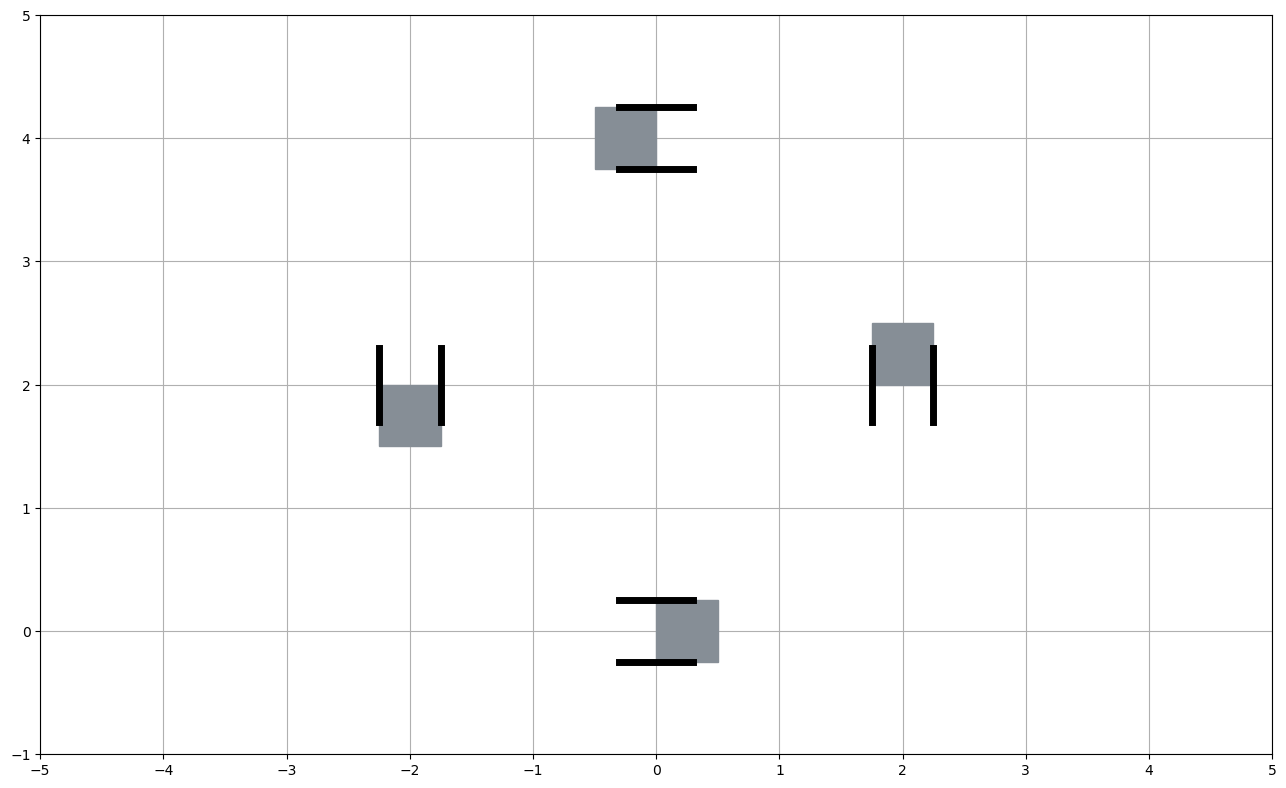

In [5]:
# 🔓
draw_arena(-5, 5, -1, 5)
draw_wheelchair(0, 0, 0)
draw_wheelchair(2, 2, pi/2)
draw_wheelchair(0, 4, pi)
draw_wheelchair(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

🔓
$$
\begin{array}{rcl}
\dot{x} &=& R_w  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& R_w  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R_w  \frac{\omega_r - \omega_l}{L} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

🔓 The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

🔓 When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 (L/R_w)  \theta^2$, we end up with $\dot{\theta}(t) = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = (1 - L/4) * pi / Rw
    omega_r = (1 + L/4) * pi / Rw
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [7]:
# 🔓
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = Rw * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = Rw * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = Rw * (omega_r - omega_l) / L
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - L/4)  \pi / R \mbox{ rad/s}$ and $\omega_r = (1 + L/4)  \pi / R_w \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [8]:
# 🔓
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

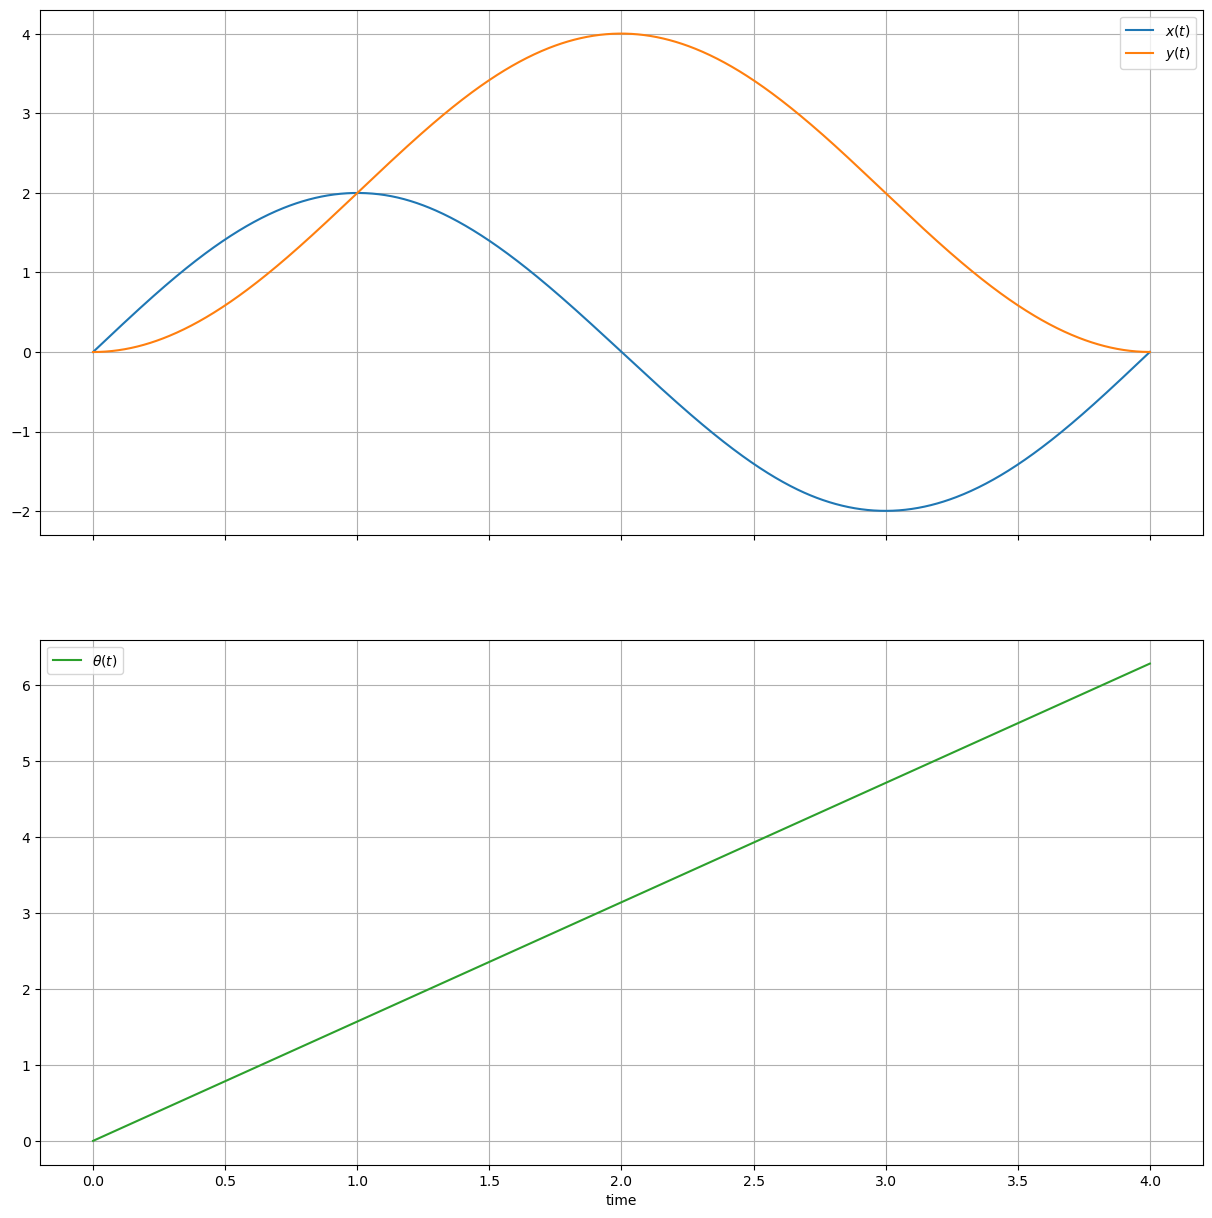

In [9]:
# 🔓
t = linspace(0.0, 4.0, 1000)
x, y, theta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

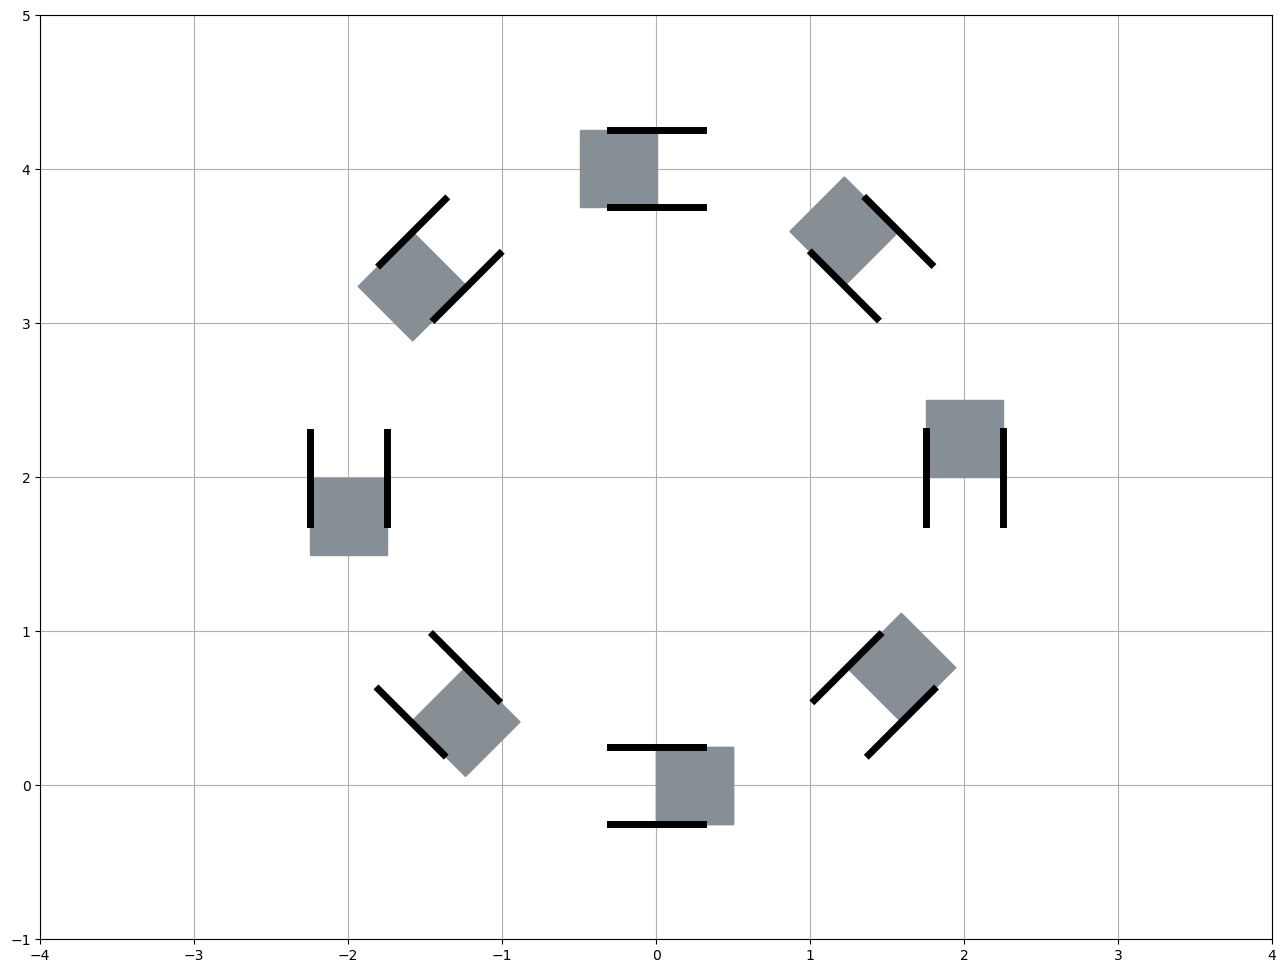

In [10]:
# 🔓
t = linspace(0.0, 4.0, 4*2+1)
sol_t = r["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

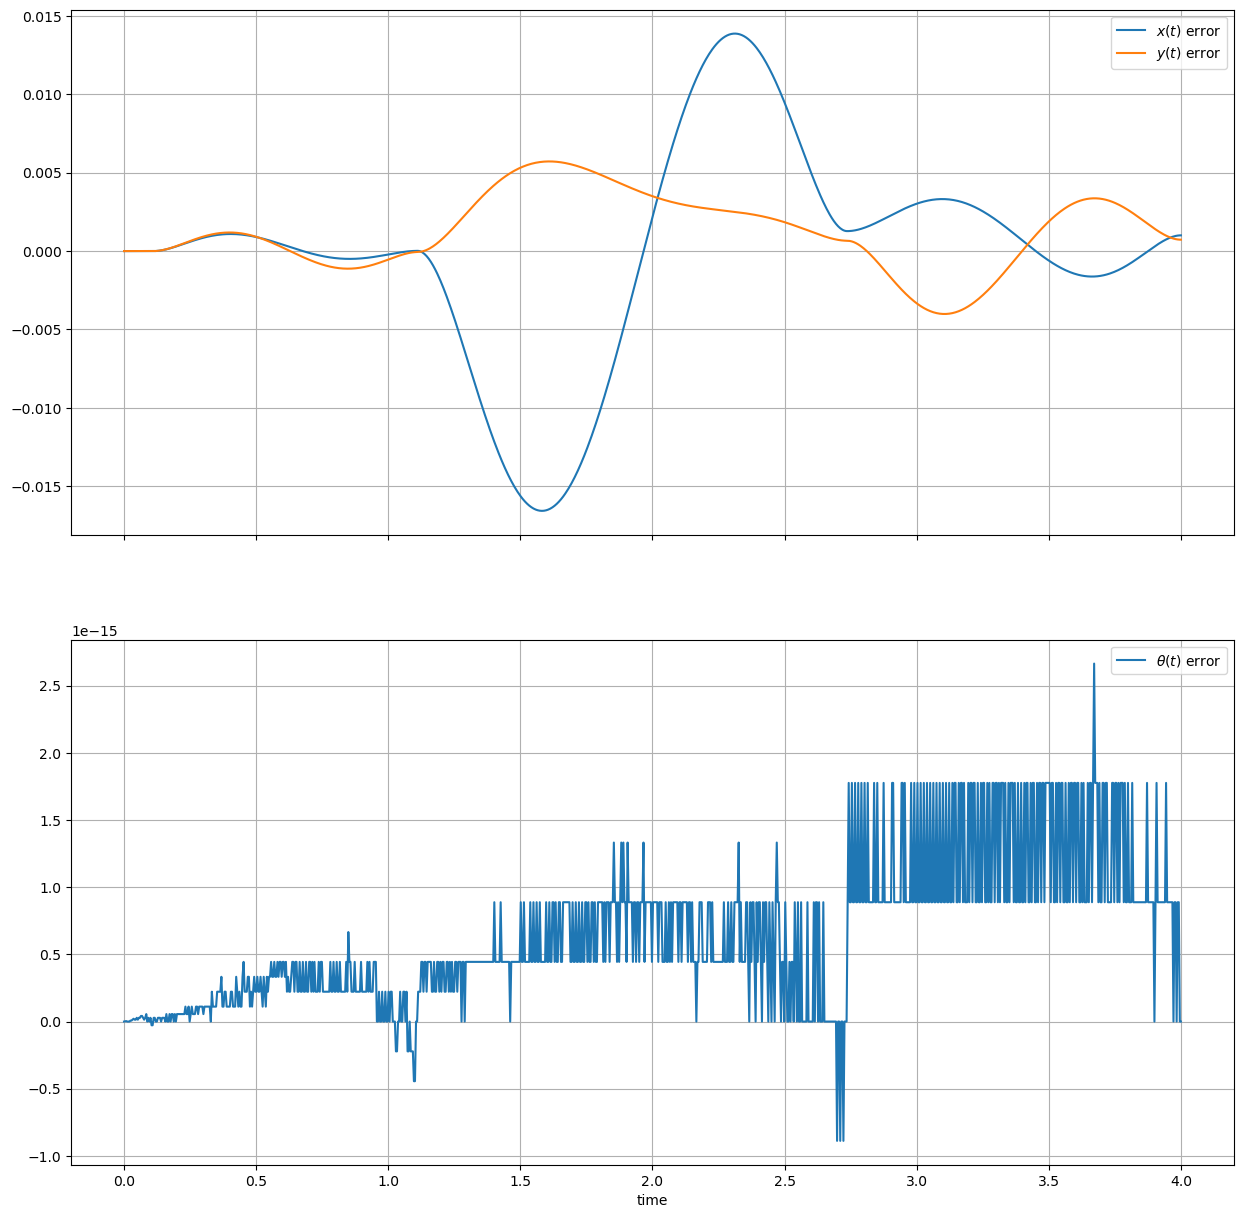

In [11]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $2 \times 10^{-5}$ for every component of $(x, y, \theta)$.

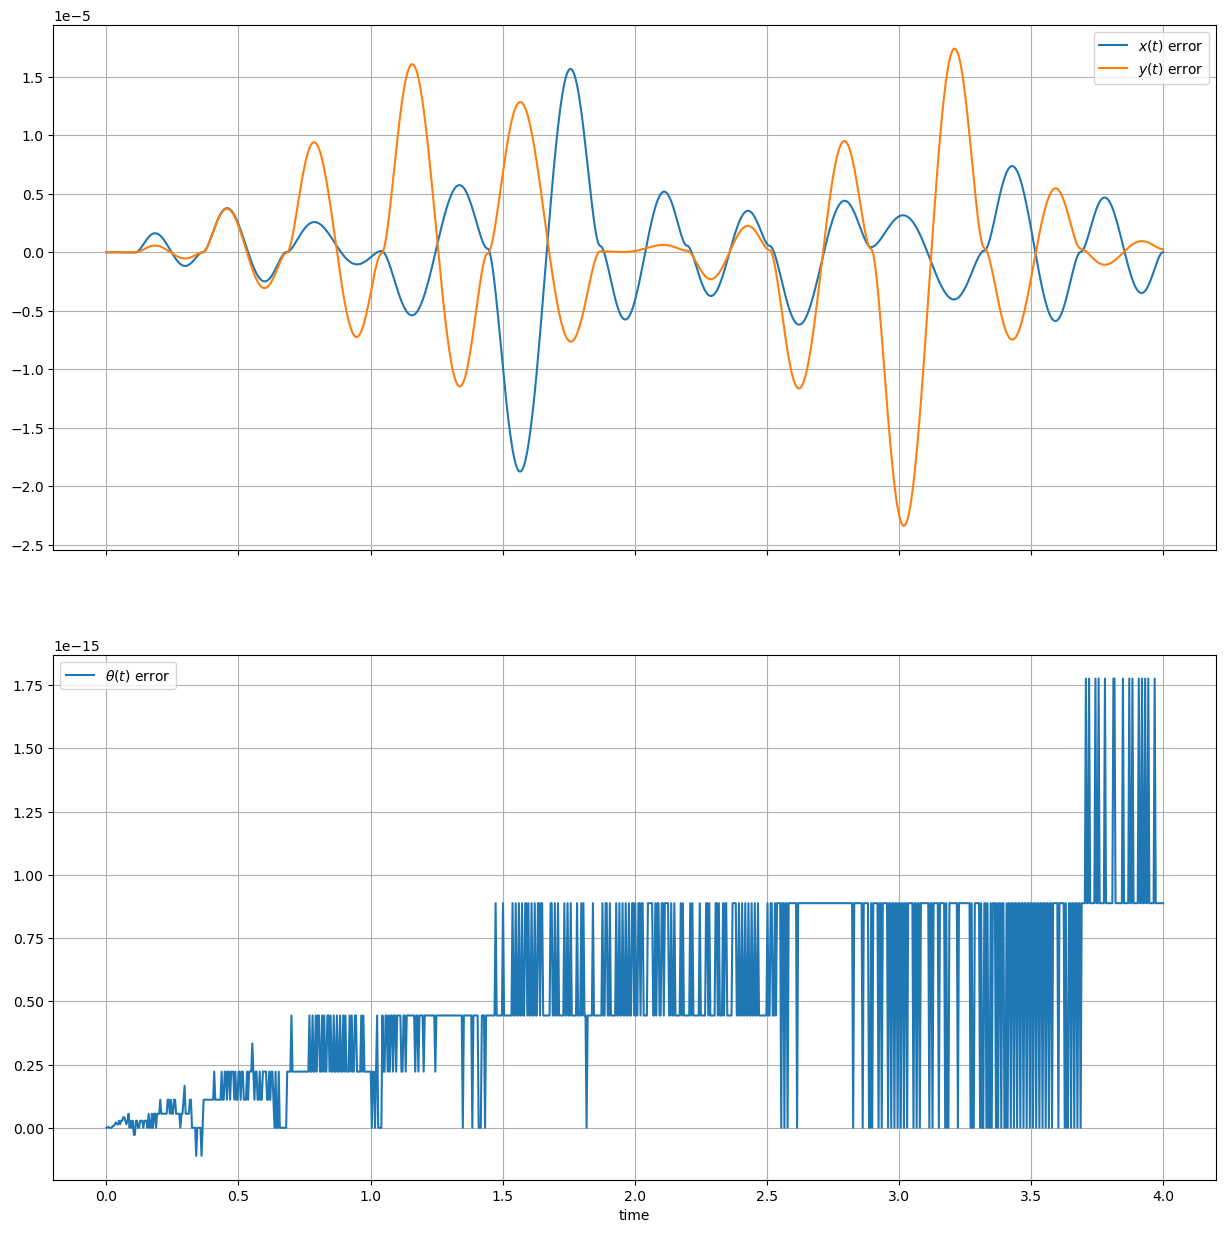

In [12]:
r = solve_ivp(
    fun=fun, 
    t_span=(0.0, 4.0), 
    y0=[0.0, 0.0, 0.0], 
    rtol=1e-6, 
    atol=1e-12, 
    dense_output=True
)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

Step 2 - Control Implementation
===============================

Time dependent inputs
---------------------

We are going to simulate the case of the chariot controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 
We want a simulation lasting 5 seconds with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{rl}
           (1 - L/4) \pi / R_w & \mbox{when $t \leq 1s$ or $t \geq 3$,} \\
           (1 + L/4) \pi / R_w & \mbox{otherwise.}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{rl}
           (1 + L/4) \pi / R_w & \mbox{when $t \leq 1s$ or $t \geq 3$,} \\
           (1 - L/4) \pi / R_w & \mbox{otherwise.}
       \end{array}
    \right.
$$

##### 🧩 Provide the new definition of `omega`

In [13]:
def omega(t, xytheta):
    if t <= 1  or t>=3:
      omega_l = (1 - L/4) * pi / Rw
      omega_r = (1 + L/4) * pi / Rw
    else :
      omega_l = (1 + L/4) * pi / Rw
      omega_r = (1 - L/4) * pi / Rw
    return array([omega_l, omega_r])

##### 🧩 Make a simulation of 4s of the robot with the previous input. Use the `rtol` and `atol` that used to guarantee a precision of $2 \times 10^{-5}$ and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** It is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`. 

In [14]:
rtol = 2*10**(-5)
atol = 2*10**(-5)
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], rtol = rtol, atol = atol,dense_output=True)

🧩 Use the simulation results to display the robot location every 0.5 seconds.

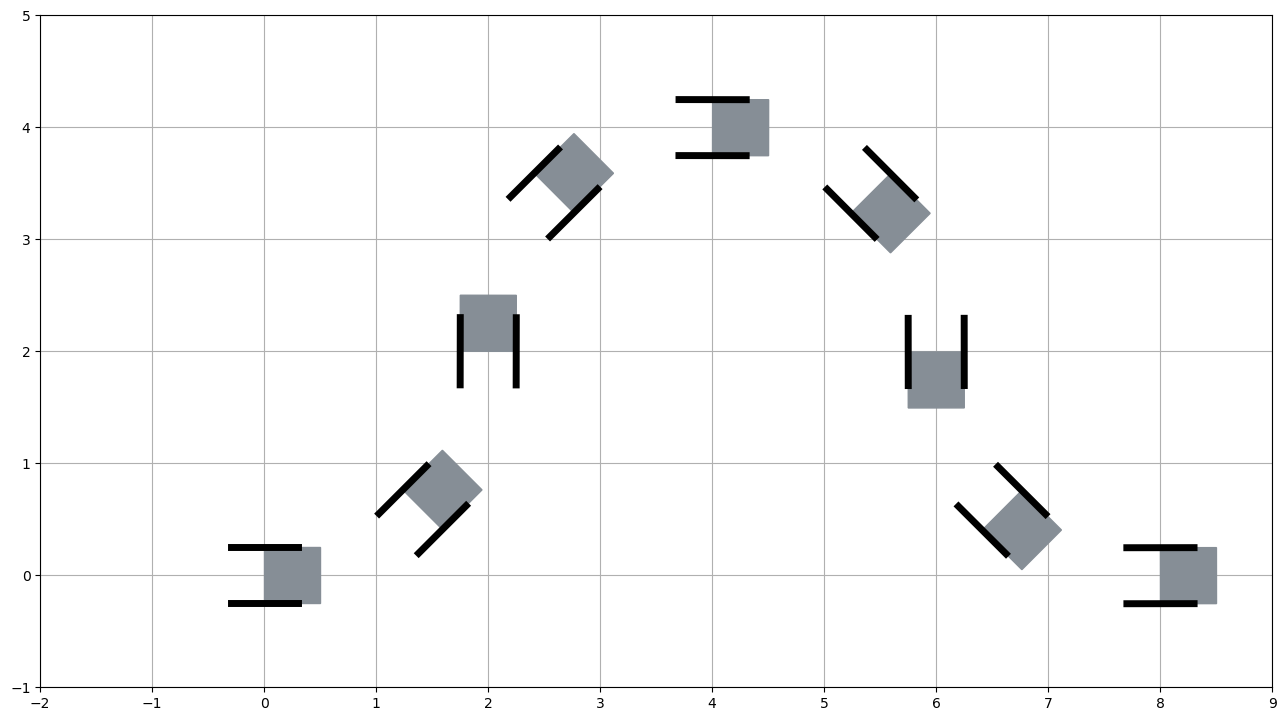

In [15]:
t = linspace(0.0, 4.0, 4*2+1)
sol_t = r["sol"](t)
draw_arena(-2, 9, -1, 5)
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)

## Analysis of the system at rest

### Equilibrium

##### 🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the wheelchair kinematic model.

**Answer:**

on a :
$\begin{pmatrix} 
         \dot{x_e}\\ 
         \dot{y_e}\\
         \dot{\theta_e}
         \end{pmatrix} =
         \begin{pmatrix} 
         \cos({\theta_e})&0\\ 
         \sin({\theta_e})&0\\
         0&1
         \end{pmatrix}
        \begin{pmatrix} 
         R_w({\omega_l}+{\omega_r})/2\\ 
         \\
         0
         \end{pmatrix} = 
         \begin{pmatrix} 
         v~cos({\theta_e})\\ 
         v~sin({\theta_e})\\
         w_l-w_r
         \end{pmatrix}\
$\
where $v = r(\omega_1 + \omega_2)/2$ is the linear velocity of the wheelchair.
$\ 
$
To show that is an equilibrium, we need to find $\omega = (\omega_1, \omega_2)$ such that $\dot{x_e} = \dot{y_e} = \dot{\theta_e} = 0$ when $X_e$ is substituted into the kinematic model.
Substituting $X_e$ into the kinematic model, we get:

$\begin{pmatrix} 
         0\\ 
         0\\
         0
         \end{pmatrix} = 
         \begin{pmatrix} 
         v~cos({\theta_e})\\ 
         v~sin({\theta_e})\\
         w_l-w_r
         \end{pmatrix}\
$


So $X_{e}$ is an equilibrium for $\omega_{e}=(0,0)$

##### 🧩 Show that for any other $\omega_e$, the system has no equilibrium.

**Answer:** 
taking the last equation of the above to equilibrium w_l = w_r


If  $\omega_{e}=(\alpha,\alpha)\neq (0,0)$:
* An  equilibrium  verify 
$\cos(\theta)=\sin(\theta)=0$ impossible since $\cos^2(\theta)+\sin^2(\theta)=1$


There is no equilibrium for $\omega_{e}\neq (0,0)$

##### 🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

**Answer:**
for $\omega_{e}=(0,0)$  $\forall X=(x,y,\theta) \in \mathbb{R}\times \mathbb{R} \times\mathbb{R}$ X is an equilibrium 

### Linearized System Model


Let $\omega = \omega_e$ and $X_e = (0,0,0)$. Let us introduce the the error variable $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$ and $\Delta \omega = \omega - \omega_e$.

##### 🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$).

**Answer:**

The non linearised system can be writen as  X˙=f(X,ω)  Where $f(X,\omega)=\begin{pmatrix}
 \frac{Rw}{2}*(\omega_l+\omega_r)*\cos(\theta)\\[0.3em]
 \frac{Rw}{2}*(\omega_l+\omega_r)*\sin(\theta)  \\[0.3em]
 \frac{Rw}{L}*(\omega_r-\omega_l)        
\end{pmatrix}$


The linearised system can be $\dot{\Delta X}=\begin{pmatrix}
0 & 0 & -\frac{Rw}{2}*(\omega_{el}+\omega_{er})*\sin(\theta_{e})\\[0.3em]
 0 & 0 & \frac{Rw}{2}*(\omega_{el}+\omega_{er})*\cos(\theta_{e})  \\[0.3em]
0 & 0 & 0        
\end{pmatrix}\times \Delta X+\begin{pmatrix} \frac{Rw}{2}\cos(\theta_{e}) & \frac{Rw}{2}\cos(\theta_{e})\\[0.3em]
\frac{Rw}{2}*\sin(\theta_{e})  & \frac{Rw}{2}*\sin(\theta_{e})  \\[0.3em]
-\frac{Rw}{L} & \frac{Rw}{L}     
\end{pmatrix}\times \Delta \omega$

Pour ωe=(0,0) ,Xe=(0,0,0) On a A=\begin{pmatrix} 0 & 0 & -\frac{Rw}{2}(\omega_{el}+\omega_{er})\sin(\theta_{e})\\[0.3em] 0 & 0 & \frac{Rw}{2}(\omega_{el}+\omega_{er})\cos(\theta_{e}) \\[0.3em] 0 & 0 & 0
\end{pmatrix}

and B=\begin{pmatrix} \frac{Rw}{2}\cos(\theta_{e}) & \frac{Rw}{2}\cos(\theta_{e})\\[0.3em] \frac{Rw}{2}\sin(\theta_{e}) & \frac{Rw}{2}\sin(\theta_{e}) \\[0.3em] -\frac{Rw}{L} & \frac{Rw}{L}
\end{pmatrix}

Stability of the linearized system

So 
A=\begin{pmatrix} 0 & 0 & 0\\[0.3em] 0 & 0 & 0\\[0.3em] 0 & 0 & 0
\end{pmatrix}

and B=\begin{pmatrix} \frac{Rw}{2} & \frac{Rw}{2}\\[0.3em] 0 & 0 \\[0.3em] -\frac{Rw}{L} & \frac{Rw}{L}
\end{pmatrix}

##### 🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

**Answer:** 

As all the eigenvalues of A are zero, the equilibrium is not asymptotically stable.
for the system to be asymptotically stable each eigenvalue has a strictly negative real part which is not the case

##### 🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

🔓 **Answer:**

taking 
$\omega = \omega_e$, the system is in equilibrium and cannot "move". If $X(t_0) = X_0$, then $for all t>0, X(t) =X_0$. Thus, if $X_0\neq (0,0,0)$, $X(t)$ cannot converge to the origin: the original system is not (even locally) attractive.

Therefore, it is not AS.

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:

$$
\frac{\Delta X}{dt} = A \Delta X + B\Delta u
$$

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

**Answer:**
We suppose that the only coordonate that changes during the trajectory is $x$.

If we take the reference trajectory :\begin{matrix}
 x_R (t) = 2/tf * t -2\\
 y_R (t) = 0\\
 \theta_R (t) = 0
\end{matrix}

we find that $ x_R (0) = -2$ and $ x_R (tf) = 0$.

So there is an admissible trajectory with :          
$\omega _r =\omega _l= 2/(R_w*t_f)$

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

**Answer:**
No because the error on $y$ cannot be changed by $u$  due to the fact that $\dot{\Delta y}=0$

##### 🧩 Is the linearized system controllable?

**Answer:**
no, A is a null matrix according to KAlMAN the controllability matrix will have the same rank as B

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

##### 🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

We have  $x_R(t) = v t$ and $y_R(t) = 0$ 

So $ \dot{x}_R(t) = v $ and $\dot{y}_R(t) = 0$

taking these results back to the differential equations :
$$
\begin{array}{rcl}
\dot{x} &=& R_w  \frac{\omega_l + \omega_r}{2} \cos \theta\\
\dot{y} &=& R_w  \frac{\omega_l + \omega_r}{2} \sin \theta\\
\dot{\theta} &=& R_w  \frac{\omega_r - \omega_l}{L} \\
\end{array}
$$
we find the following results:     
$sin(\theta)=0 → \theta =0 $ or $\theta =kπ → \dot{\theta}=0$ 

We find that the admissible trajectories are $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ with We have  $x_R(t) = v t$ and $y_R(t) = 0$ and $\theta =0 $ or $\theta =kπ$ for $  k ∈N$

the differential equations become :         
$$
\begin{array}{rcl}
\ v &=& R_w  \frac{\omega_l + \omega_r}{2} \cos \theta\\
\ 0 &=& R_w  \frac{\omega_l + \omega_r}{2} \sin \theta\\
\ 0 &=& R_w  \frac{\omega_r - \omega_l}{L} \\
\end{array}
$$

So the corresponding reference control $\omega_{R}(t) = v/R_w.$

### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

##### 🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

**Answer:**
The corresponding linearized system is :     
$ f(x,ω) = AΔX + BΔω $ \\
With
$ A= \begin{pmatrix}
0 & 0 & 0\\
0 & 0 & v\\
0 & 0 & 0
\end{pmatrix}$
and 
$ B= \begin{pmatrix}
R_w/2 & R_w/2 \\
0 & 0 \\
-R_w/L & R_w/L
\end{pmatrix}$

##### 🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

**Answer:**

For the linearized system to be asymptotically stable, the matrix $A$ must have strictly negative eigenvalues.
But since the eigenvalues of $A$ are not all strictly negative, the linearized system is not asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ 

##### 🧩 Is the system attractive, with $\Delta\omega(t)=0$?








We have the linearized system  :     
$ f(x,ω) = AΔX $ \\
so 
$ \Delta \dot{x} = 0$
meaning $ \Delta x = cste$
 so x doesnt change a lot from the reference
 and according to initial conditions $y$ and $\theta$ do not change.

So $X$ function converges to the equilibrum.
So the system is attractive.

##### 🧩 Show that the linearized system is controllable.

**Answer:** 
on a: 

la matrice de Kalman pour notre system  $ K_w= [B, AB,A^2B]$
A^2 est une matrice nulle donc $A^2$ B aussi 
$$AB=
\begin{bmatrix}
    0 & 0\\
    -v \frac {R_w}L & v \frac {R_w}L \\
    0 & 0
\end{bmatrix}
$$
$$K_w=
\begin{bmatrix}
    \frac {R_w}2 & \frac {R_w}2 & 0 & 0 &0&0\\
    0 & 0 & -v \frac {R_w}L & v \frac {R_w}L &0&0\\
    -\frac {R_w}2 & \frac {R_w}2 & 0 & 0&0&0
\end{bmatrix}
$$

The submatrix defined by keeping the 3 first columns if full rank. So, the controllability matrix is also full rank and the system is controllable.

### Linearized system implementation

In the sequel, we will use $v=4.8 \mbox{ km/h}$.

##### 🧩 Implement and print the matrices $A$ and $B$

In [16]:
v=4800/3600

A=array([[0,0,0],[0,0,v],[0,0,0]])
B=array([[Rw/2,Rw/2],[0,0],[-Rw/L,Rw/L]])
print(A)
print(B)

[[0.         0.         0.        ]
 [0.         0.         1.33333333]
 [0.         0.         0.        ]]
[[ 0.15  0.15]
 [ 0.    0.  ]
 [-0.6   0.6 ]]


The linear model has to be fed with some $\Delta\omega$ input. Like for the nonlinear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we set:

In [17]:
def deltaOmega(t, deltaX):
    return array([0, 0, 0])

##### 🧩 Using this function `deltaOmega`, define a function `lin_fun` that computes $d{\Delta X}/dt$ given the arguments `t` and `deltaX`$.

In [18]:
def lin_fun(t, deltaX):
    return A@deltaX + B@deltaOmega(t,deltaX)

### Controller Design on the linearized system

##### 🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. 

For this question, we will chose 3 real poles close to -0.5.

Then, print the poles of the closed-loop system

$$
\frac{d\Delta X}{dt}= A \Delta X + B\Delta\omega
\; \mbox{ with } \;
\Delta\omega = -K \Delta X.
$$

In [19]:
from scipy.signal import place_poles
poles=[-0.48,-0.51,-0.52]
K=place_poles(A,B,poles).gain_matrix

print(eig(A-B@K)[0])

[-0.51+0.j -0.52+0.j -0.48+0.j]


##### 🧩 Simulate the linearized system during 20s, with the initial condition $\Delta X(0) = (0,2,0)$.

In [20]:
def deltaOmega(t,deltaX):
  return -K@deltaX

tf=20
r=solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True,rtol=rtol,atol=atol)

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

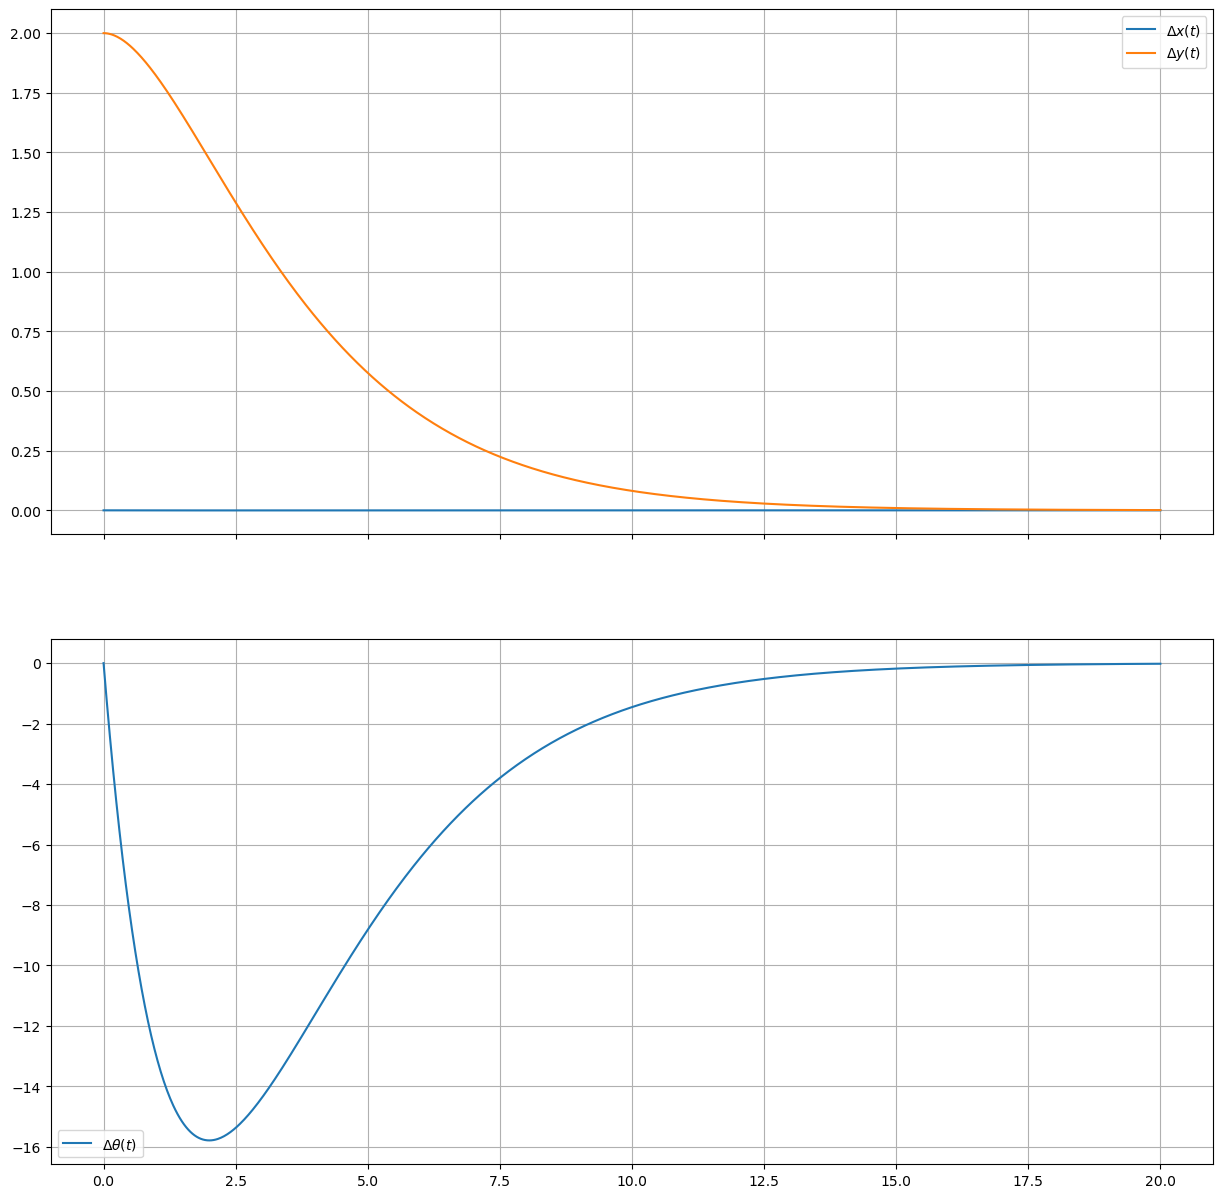

In [21]:
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

##### 🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

**Answer:**


<div style="background:orange">

None

</div>

##### 🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [22]:
dX = r["sol"](t)
dOme = -K@dX
dOme_l = dOme[0,:]
dOme_r = dOme[1,:]

##### 🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

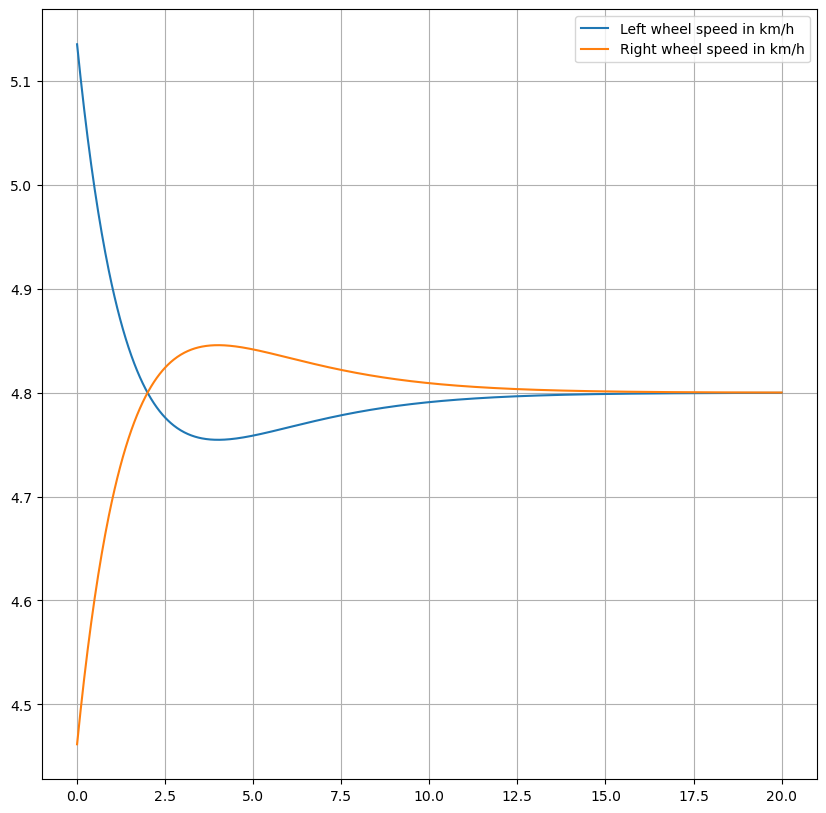

In [23]:
ome_l = dOme_l +v/Rw
ome_r = dOme_r +v/Rw

fig=figure(figsize=(10, 10))
plot(t,ome_l*Rw*3.6, label=r"Left wheel speed in km/h")
plot(t,ome_r*Rw*3.6, label=r"Right wheel speed in km/h")
grid()
legend()

##### 🧩 Are these control values consistent with what the robot should do to cancel the error?

<div style="background:orange">

</div>

**Answer:**

<div style="background:orange">

None

</div>

###  Controller Tuning



##### 🧩 Tune the poles (and recompute the gain matrix) so that the actual location $(x, y)$ is within 10 cm of the desired location within 20 sec and the linear velocity of each wheel never exceeds $5$ km/h. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

In [24]:
from scipy.signal import place_poles
poles=[-0.48,-0.51,-0.52]
K=place_poles(A,B,poles).gain_matrix

print(eig(A-B@K)[0])

[-0.51+0.j -0.52+0.j -0.48+0.j]


In [25]:
r=solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,0.1,0],dense_output=True,rtol=rtol,atol=atol)

<div style="background:orange">

The aim was to meet the objectives **with the same initial condition**, not one that is closer to the desired one.

</div>

In [26]:
dX = r["sol"](t)
dOme = -K@dX
dOme_l = dOme[0,:]
dOme_r = dOme[1,:]
ome_l = dOme_l +v/Rw
ome_r = dOme_r +v/Rw

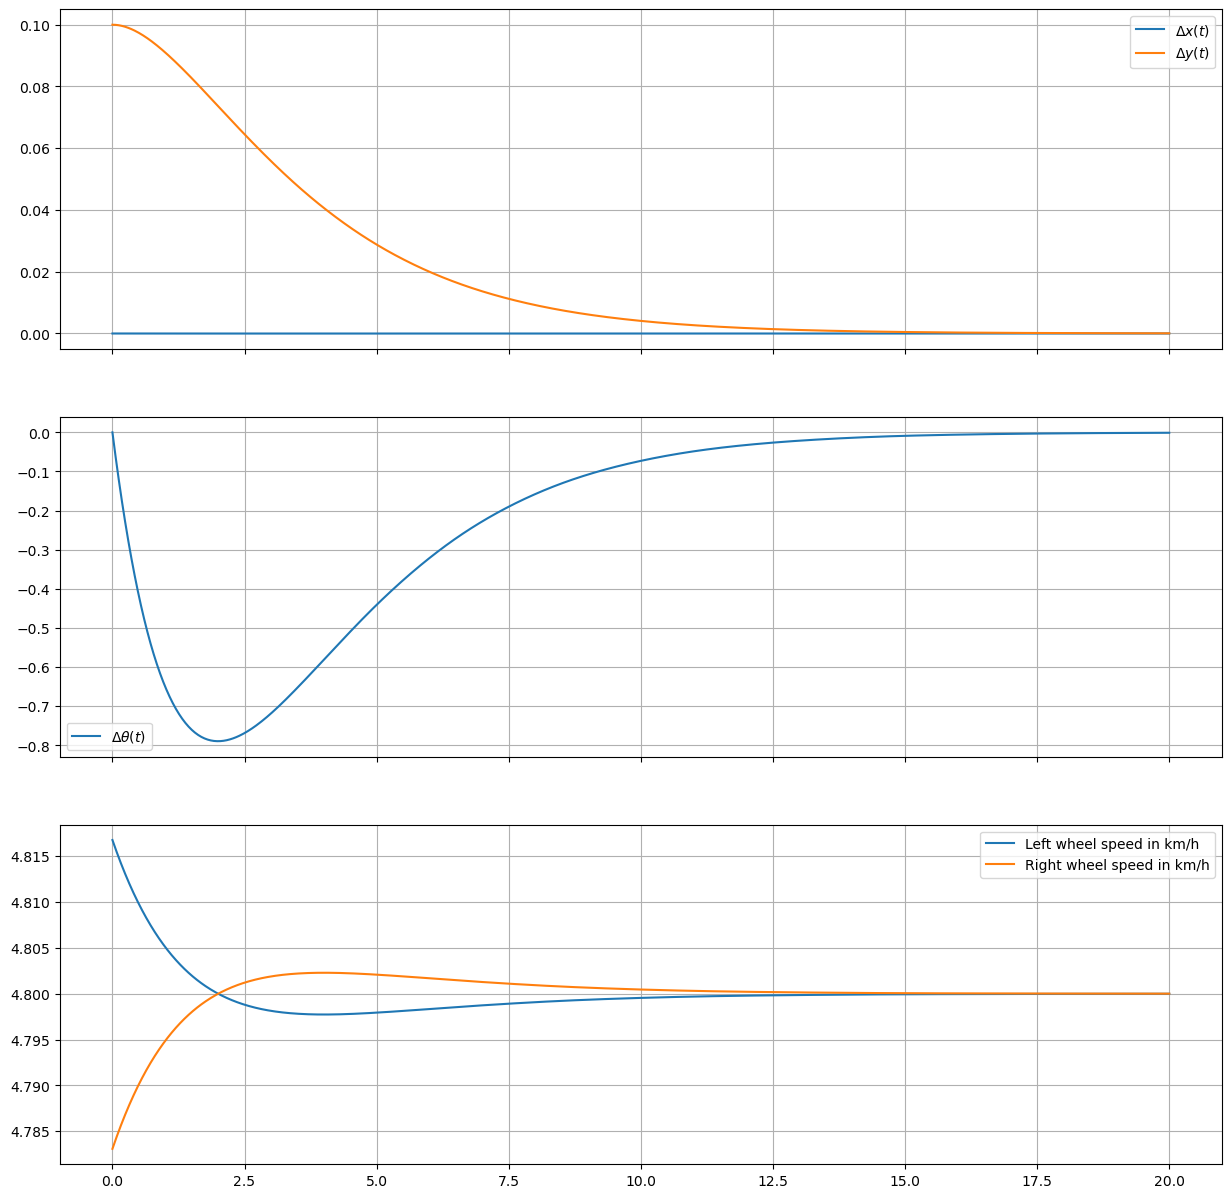

In [27]:
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = dX
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()
ax3.plot(t,ome_l*Rw*3.6, label=r"Left wheel speed in km/h")
ax3.plot(t,ome_r*Rw*3.6, label=r"Right wheel speed in km/h")
ax3.legend()
ax3.grid()

##### 🧩 Simulate the initial, nonlinear wheelchair model when the control law computed in the section "Controller Tuning" is applied. Check that the constraint given for the control law design still hold.

In [28]:
r=solve_ivp(fun=fun,t_span=[0,tf],y0=[0,0.1,0],dense_output=True,rtol=rtol,atol=atol)

In [29]:
X_t = r["sol"](t)


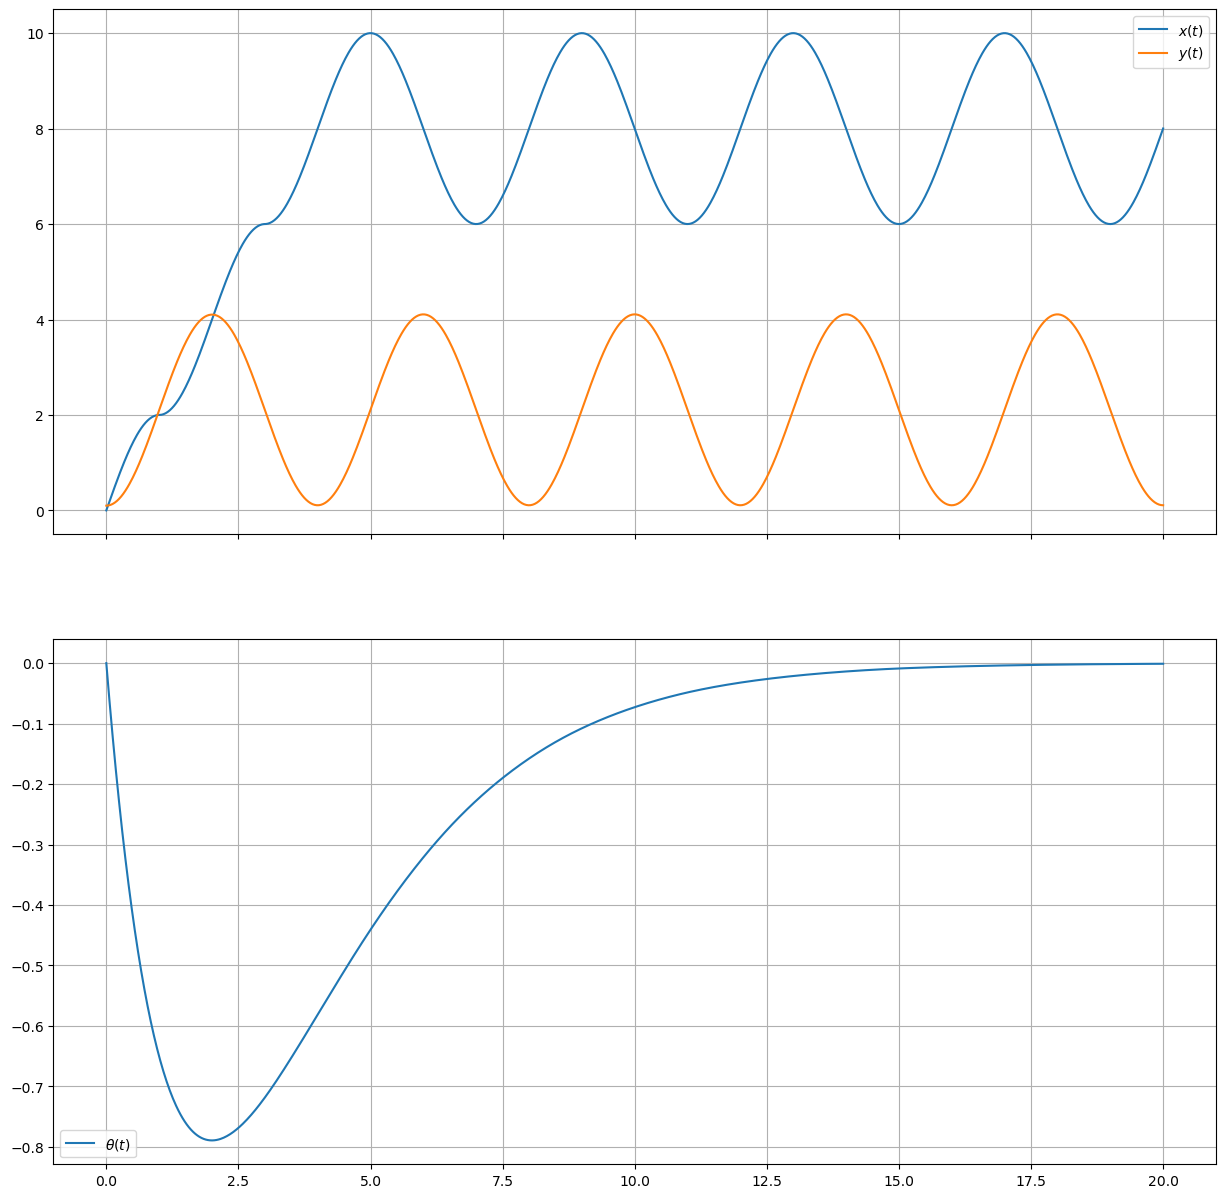

In [30]:
t = linspace(0.0,tf, 1000)
x, y, theta = X_t
fig=figure(figsize=(15, 15))
ax1, ax2= fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\theta(t)$")
ax2.legend()

We can verify that x and y are always less than 10 cm, so that the control conditions are verified.

##### 🧩 Display this trajectory using a snapshot of the wheelchair in the plane every second.

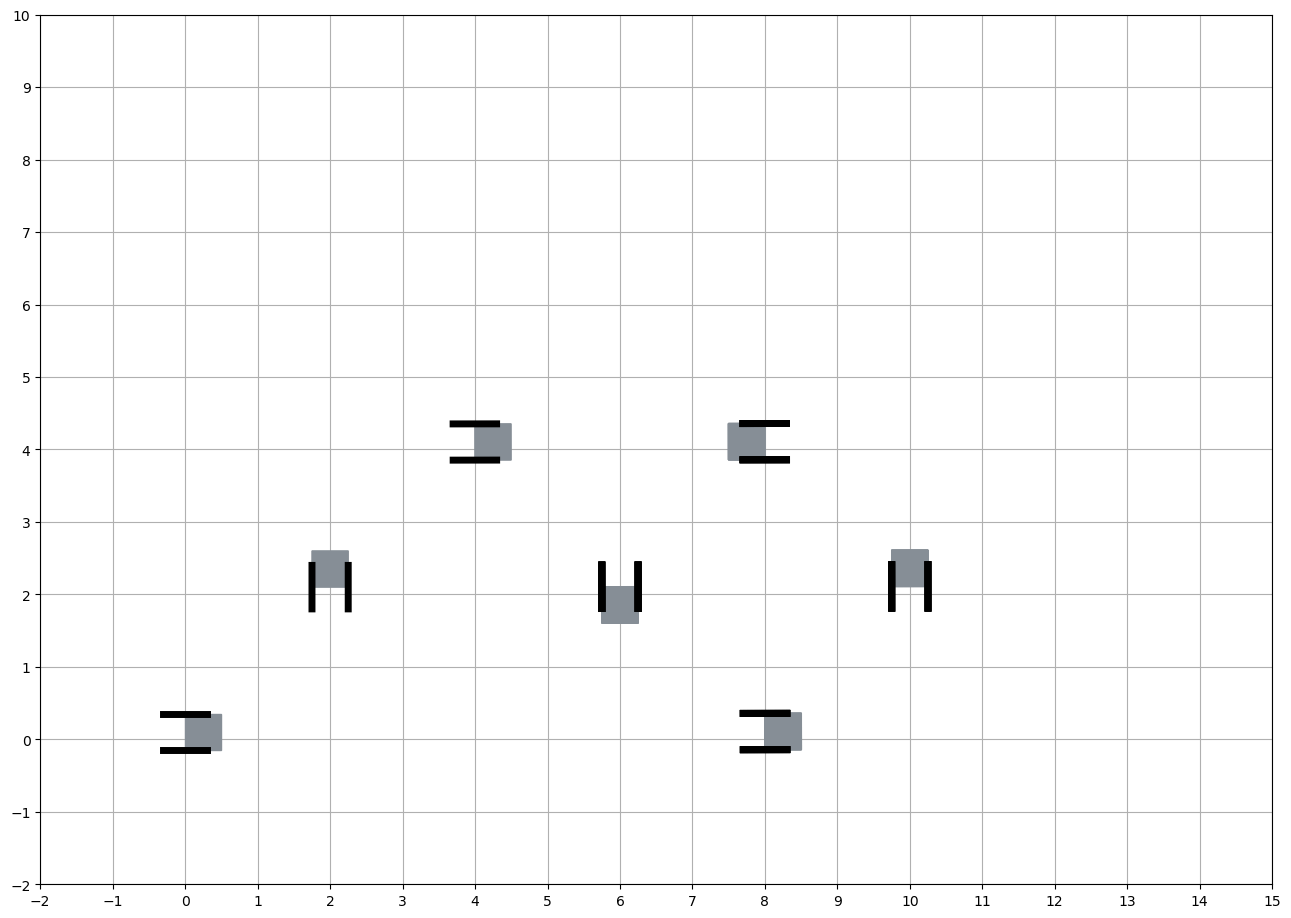

In [31]:
t = linspace(0.0, 20.0, 20+1)
sol_t = r["sol"](t)
draw_arena(-2,15 , -2, 10)
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)